In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
NOAK = True

In [3]:
if NOAK:
  csv_path = './results/results_heat_process_deployment_noak_1000.csv'
  clean_save_path = './results/results_heat_process_deployment_noak_1000_clean.csv'
  save_fig_path = './results/breakeven_price_heat_noak_1000.png'
else:
  csv_path = './results/results_heat_process_deployment.csv'
  clean_save_path = './results/results_heat_process_deployment_clean.csv'
  save_fig_path = './results/breakeven_price_heat.png'
df = pd.read_csv(csv_path)
df.sort_values(by=['Breakeven NG price ($/MMBtu)'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df.head(3)

,FACILITY_ID,H2 Dem. (kg/day),Heat Dem. (MJ/year),Alkaline,HTSE,PEM,ANR type,# ANR modules,Cost ($/year),Ann. carbon emissions (kgCO2eq/year),Breakeven NG price ($/MMBtu)
0,1000588,153100.342414,7.928485e+09,0,154.0,0,iMSR,1,-9.870052e+07,1.444336e+07,13.134232
1,1007177,150959.177564,7.817602e+09,0,151.0,0,iMSR,1,-9.775323e+07,1.416200e+07,13.192679
2,1000418,433411.991729,2.244476e+10,0,434.0,0,iMSR,3,-2.855360e+08,4.070402e+07,13.422129


In [4]:
anr_param = pd.read_excel('ANRs.xlsx', sheet_name='FOAK')
anr_param

,Reactor,Type,Power in MWe,Power in MWt,MSL in MWe,Thermal Efficiency,Thermal transfer efficiency,MDT in hours,Ramp Rate (fraction of capacity/hr),Ramp Rate (MW/hr),Outlet Temp (C),CAPEX $/MWe,FOPEX $/MWe-y,Max Modules,VOM in $/MWh-e,Startupfixedcost in $,Life (y)
0,iPWR,PWR,77.0,250,15.4,0.31,1.000,20,0.4,24.0,302,5535000,115000,12,0.75,38500,30
1,HTGR,HTGR,164.0,350,32.8,0.47,0.897,20,6.0,984.0,950,7500000,164000,4,0.00,82000,30
2,PBR-HTGR,HTGR,80.0,200,32.0,0.40,0.751,20,2.4,48.0,750,4569000,100000,12,0.00,40000,30
3,iMSR,MSR,141.0,300,28.2,0.47,0.936,20,0.6,84.6,700,4091000,85000,12,0.50,70500,30
4,Micro,HTGR,6.7,20,2.7,0.33,0.897,20,6.0,24.0,630,10902000,264000,12,0.00,3350,30


### Compute deployed power at each steel plant and cumulative deployed ANR capacity

In [5]:
anr_thermal_power = anr_param[['Power in MWt', 'Reactor']]
anr_thermal_power
df = df.merge(anr_thermal_power, how='inner', left_on=['ANR type'], right_on=['Reactor'])
df.sort_values(by=['Breakeven NG price ($/MMBtu)'], inplace=True)
df['Deployed Power (MWt)'] = df['Power in MWt']*df['# ANR modules']
df['ANR Nameplate Capacity (GWt)'] = df['Deployed Power (MWt)'].cumsum()/1000
df

,FACILITY_ID,H2 Dem. (kg/day),Heat Dem. (MJ/year),Alkaline,HTSE,PEM,ANR type,# ANR modules,Cost ($/year),Ann. carbon emissions (kgCO2eq/year),Breakeven NG price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt)
0,1000588,153100.342414,7.928485e+09,0,154.0,0,iMSR,1,-9.870052e+07,1.444336e+07,13.134232,300,iMSR,300,0.30
1,1007177,150959.177564,7.817602e+09,0,151.0,0,iMSR,1,-9.775323e+07,1.416200e+07,13.192679,300,iMSR,300,0.60
2,1000418,433411.991729,2.244476e+10,0,434.0,0,iMSR,3,-2.855360e+08,4.070402e+07,13.422129,300,iMSR,900,1.50
9,1000630,177254.463397,9.179335e+09,0,178.0,0,PBR-HTGR,2,-1.176838e+08,1.609177e+07,13.526357,200,PBR-HTGR,400,1.90
3,1005198,141178.307699,7.311088e+09,0,142.0,0,iMSR,1,-9.393104e+07,1.331791e+07,13.555095,300,iMSR,300,2.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1006336,233.209349,1.207703e+07,0,1.0,0,Micro,1,-5.071041e+06,7.524490e+04,443.008999,20,Micro,20,21.42
289,1005537,199.690785,1.034123e+07,0,1.0,0,Micro,1,-5.061254e+06,7.524490e+04,516.370577,20,Micro,20,21.44
290,1006263,185.983880,9.631398e+06,0,1.0,0,Micro,1,-5.057251e+06,7.524490e+04,553.988368,20,Micro,20,21.46
291,1002884,74.293726,3.847390e+06,0,1.0,0,Micro,1,-5.024639e+06,7.524490e+04,1377.888702,20,Micro,20,21.48


### Compute cumulative number of viable steel plants and ANR modules

In [6]:
df['Viable ANR modules count'] = df['# ANR modules'].cumsum()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df['Viable ANR plants count'] = df.index+1
df.head(5)

,FACILITY_ID,H2 Dem. (kg/day),Heat Dem. (MJ/year),Alkaline,HTSE,PEM,ANR type,# ANR modules,Cost ($/year),Ann. carbon emissions (kgCO2eq/year),Breakeven NG price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Viable ANR modules count,Viable ANR plants count
0,1000588,153100.342414,7.928485e+09,0,154.0,0,iMSR,1,-9.870052e+07,1.444336e+07,13.134232,300,iMSR,300,0.3,1,1
1,1007177,150959.177564,7.817602e+09,0,151.0,0,iMSR,1,-9.775323e+07,1.416200e+07,13.192679,300,iMSR,300,0.6,2,2
2,1000418,433411.991729,2.244476e+10,0,434.0,0,iMSR,3,-2.855360e+08,4.070402e+07,13.422129,300,iMSR,900,1.5,5,3
3,1000630,177254.463397,9.179335e+09,0,178.0,0,PBR-HTGR,2,-1.176838e+08,1.609177e+07,13.526357,200,PBR-HTGR,400,1.9,7,4
4,1005198,141178.307699,7.311088e+09,0,142.0,0,iMSR,1,-9.393104e+07,1.331791e+07,13.555095,300,iMSR,300,2.2,8,5


### Compute avoided carbon emissions 

In [7]:
demand_heat_df = pd.read_excel('./h2_demand_industry_heat.xlsx', sheet_name='max')
demand_heat_df = demand_heat_df[['FACILITY_ID', 'MMTCO2E']]
demand_heat_df.head(3)

,FACILITY_ID,MMTCO2E
0,1000022,0.004963
1,1000029,0.033338
2,1000056,0.041385


In [8]:
df = df.merge(demand_heat_df, on='FACILITY_ID')
df.head(3)

,FACILITY_ID,H2 Dem. (kg/day),Heat Dem. (MJ/year),Alkaline,HTSE,PEM,ANR type,# ANR modules,Cost ($/year),Ann. carbon emissions (kgCO2eq/year),Breakeven NG price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Viable ANR modules count,Viable ANR plants count,MMTCO2E
0,1000588,153100.342414,7.928485e+09,0,154.0,0,iMSR,1,-9.870052e+07,1.444336e+07,13.134232,300,iMSR,300,0.3,1,1,0.399145
1,1007177,150959.177564,7.817602e+09,0,151.0,0,iMSR,1,-9.775323e+07,1.416200e+07,13.192679,300,iMSR,300,0.6,2,2,0.393562
2,1000418,433411.991729,2.244476e+10,0,434.0,0,iMSR,3,-2.855360e+08,4.070402e+07,13.422129,300,iMSR,900,1.5,5,3,1.129939


In [9]:
df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = df.apply(lambda row: row['MMTCO2E']- row['Ann. carbon emissions (kgCO2eq/year)']/1e9, axis=1)
df['Viable avoided emissions (MMT-CO2/year)'] = df['Ann. avoided CO2 emissions (MMT-CO2/year)'].cumsum()
df

,FACILITY_ID,H2 Dem. (kg/day),Heat Dem. (MJ/year),Alkaline,HTSE,PEM,ANR type,# ANR modules,Cost ($/year),Ann. carbon emissions (kgCO2eq/year),Breakeven NG price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Viable ANR modules count,Viable ANR plants count,MMTCO2E,Ann. avoided CO2 emissions (MMT-CO2/year),Viable avoided emissions (MMT-CO2/year)
0,1000588,153100.342414,7.928485e+09,0,154.0,0,iMSR,1,-9.870052e+07,1.444336e+07,13.134232,300,iMSR,300,0.30,1,1,0.399145,0.384701,0.384701
1,1007177,150959.177564,7.817602e+09,0,151.0,0,iMSR,1,-9.775323e+07,1.416200e+07,13.192679,300,iMSR,300,0.60,2,2,0.393562,0.379400,0.764102
2,1000418,433411.991729,2.244476e+10,0,434.0,0,iMSR,3,-2.855360e+08,4.070402e+07,13.422129,300,iMSR,900,1.50,5,3,1.129939,1.089235,1.853337
3,1000630,177254.463397,9.179335e+09,0,178.0,0,PBR-HTGR,2,-1.176838e+08,1.609177e+07,13.526357,200,PBR-HTGR,400,1.90,7,4,0.462116,0.446025,2.299361
4,1005198,141178.307699,7.311088e+09,0,142.0,0,iMSR,1,-9.393104e+07,1.331791e+07,13.555095,300,iMSR,300,2.20,8,5,0.368063,0.354745,2.654106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1006336,233.209349,1.207703e+07,0,1.0,0,Micro,1,-5.071041e+06,7.524490e+04,443.008999,20,Micro,20,21.42,467,289,0.000608,0.000533,17.332984
289,1005537,199.690785,1.034123e+07,0,1.0,0,Micro,1,-5.061254e+06,7.524490e+04,516.370577,20,Micro,20,21.44,468,290,0.000521,0.000445,17.333429
290,1006263,185.983880,9.631398e+06,0,1.0,0,Micro,1,-5.057251e+06,7.524490e+04,553.988368,20,Micro,20,21.46,469,291,0.000485,0.000410,17.333839
291,1002884,74.293726,3.847390e+06,0,1.0,0,Micro,1,-5.024639e+06,7.524490e+04,1377.888702,20,Micro,20,21.48,470,292,0.000194,0.000118,17.333958


### Save clean version of results


In [10]:
df_clean = df[["FACILITY_ID", 'H2 Dem. (kg/day)', 'HTSE', 'ANR type', '# ANR modules', 'Cost ($/year)','Breakeven NG price ($/MMBtu)', 'Ann. avoided CO2 emissions (MMT-CO2/year)']]
df_clean


,FACILITY_ID,H2 Dem. (kg/day),HTSE,ANR type,# ANR modules,Cost ($/year),Breakeven NG price ($/MMBtu),Ann. avoided CO2 emissions (MMT-CO2/year)
0,1000588,153100.342414,154.0,iMSR,1,-9.870052e+07,13.134232,0.384701
1,1007177,150959.177564,151.0,iMSR,1,-9.775323e+07,13.192679,0.379400
2,1000418,433411.991729,434.0,iMSR,3,-2.855360e+08,13.422129,1.089235
3,1000630,177254.463397,178.0,PBR-HTGR,2,-1.176838e+08,13.526357,0.446025
4,1005198,141178.307699,142.0,iMSR,1,-9.393104e+07,13.555095,0.354745
...,...,...,...,...,...,...,...,...
288,1006336,233.209349,1.0,Micro,1,-5.071041e+06,443.008999,0.000533
289,1005537,199.690785,1.0,Micro,1,-5.061254e+06,516.370577,0.000445
290,1006263,185.983880,1.0,Micro,1,-5.057251e+06,553.988368,0.000410
291,1002884,74.293726,1.0,Micro,1,-5.024639e+06,1377.888702,0.000118


In [11]:
df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
df_clean['H2 Dem. (kg/day)'] = df_clean['H2 Dem. (kg/day)'].apply(lambda x:np.round(x/1e3,2))
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Cost ($/year)']/df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Avoided cost of CO2 ($/ton)'].apply(lambda x:np.round(np.abs(x)/1e6,1))
df_clean['Cost ($/year)'] = df_clean['Cost ($/year)'].apply(lambda x: np.round(-x/1e6,1))
df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']= df_clean.apply(lambda x: np.round(x['Ann. avoided CO2 emissions (MMT-CO2/year)'],3), axis=1)

df_clean["Breakeven NG price ($/MMBtu)"] = df_clean.apply(lambda row : np.round(row['Breakeven NG price ($/MMBtu)'],1), axis=1)
df_clean.rename(columns={'H2 Dem. (kg/day)': 'Demand (MT H2/day)',
                         'Cost ($/year)': 'Cost (M$/year)', 
                         'ANR type': 'ANR', 
                         '# ANR modules': '#'}, inplace=True)
df_clean.sort_values(by=['Breakeven NG price ($/MMBtu)'], inplace=True)
df_clean.to_csv(clean_save_path, index=False)

C:\Users\mgarrou\AppData\Local\Temp\ipykernel_11068\1656952344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_11068\1656952344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['H2 Dem. (kg/day)'] = df_clean['H2 Dem. (kg/day)'].apply(lambda x:np.round(x/1e3,2))
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_11068\1656952344.py:3: SettingWithCopyWarning: 
A value is trying to be set on a c

### Plots

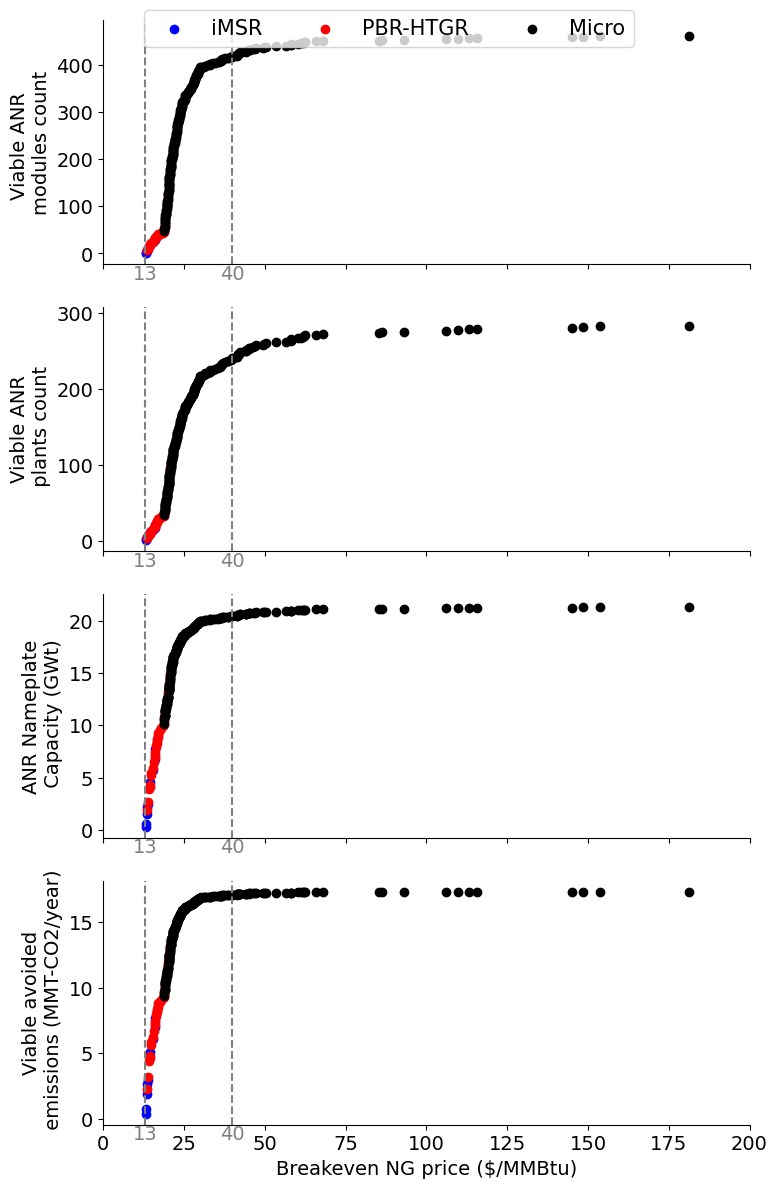

In [12]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 14

# Create subplots
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 12))

# Get unique ANR types and assign colors
anr_types = df['ANR type'].unique()

colors = ['blue', 'red', 'black']  # Adjust the colors according to the unique ANR types
# Initialize empty handles for legend
handles = []
# Plotting the data as scatter plots with different colors for each ANR type
labels = {'Viable ANR modules count': 'Viable ANR \nmodules count', 
            'Viable ANR plants count': 'Viable ANR\n plants count', 
            'ANR Nameplate Capacity (GWt)': 'ANR Nameplate\n Capacity (GWt)',
            'Viable avoided emissions (MMT-CO2/year)': 'Viable avoided\n emissions (MMT-CO2/year)'}
for i, col in enumerate(['Viable ANR modules count', 'Viable ANR plants count', 'ANR Nameplate Capacity (GWt)', 'Viable avoided emissions (MMT-CO2/year)']):
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs[i].scatter(subset['Breakeven NG price ($/MMBtu)'], subset[col], color=color, label=f'{anr_type}')
    axs[i].set_ylabel(labels[col])

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

    axs[i].set_xlim([0,200])

    # Adding vertical lines
    vertical_lines = [13, 40]
    for line in vertical_lines:
        axs[i].axvline(x=line, linestyle='--', color='grey')
        axs[i].text(line, axs[i].get_ylim()[0], str(line), color='grey', va='top', ha='center')
# Setting the title and labels
plt.xlabel('Breakeven NG price ($/MMBtu)')


# Add a common legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(anr_types))
fig.tight_layout()
#plt.show()
plt.savefig(save_fig_path)